Лабораторна робота № 9

Тема: Створення власного набору даних та розробка моделі бінарної класифікації за допомогою згорткової нейронної мережі (CNN). Варіант: 9 Виконав: Лаптєв Олександр

Мета роботи
Створити та підготувати власний набір даних, розробити архітектуру CNN, навчити модель та оцінити її ефективність за метриками Accuracy, Precision, Recall, F1-score.

Теоретичні відомості
Бінарна класифікація — це розподіл об'єктів на два класи. У нейронних мережах для цього використовується вихідний нейрон з активацією sigmoid (ймовірність від 0 до 1) та функція втрат binary_crossentropy.



Згорткові нейронні мережі (CNN) складаються з :

Conv2D: Виділення ознак (контурів, текстур).

MaxPooling2D: Зменшення розмірності зображення.

Flatten: Перетворення матриць у вектор.

Dense: Класифікація.

Dropout: Запобігання перенавчанню.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import PIL
from PIL import Image

# Налаштування розміру графіків
plt.rcParams['figure.figsize'] = (10, 6)
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


Опис та попередня обробка набору даних
Згідно з завданням, обрано тему для класифікації
використано датасет "Pizza vs Steak"
Вимоги до даних :
Мінімум 100 зразків для навчання.

Мінімум 20 зразків для тестування.

Структура папок: dataset/train та dataset/test.

In [7]:
import pathlib

# --- 1. НАЛАШТУВАННЯ ШЛЯХІВ ---
# Вказуємо шлях до вашої розпакованої папки
# Використовуємо r"" (raw string), щоб уникнути помилок зі слешами у Windows
dataset_dir = r"D:\pizza_steak\pizza_steak"

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Перевірка, чи шляхи існують
if not os.path.exists(train_dir):
    print(f"ПОМИЛКА: Папка не знайдена: {train_dir}")
else:
    print(f"Шлях до train: {train_dir}")
    print(f"Шлях до test: {test_dir}")

# --- 2. ПЕРЕВІРКА НА ПОШКОДЖЕНІ ФАЙЛИ ---
# Це важливо, щоб навчання не переривалося через помилки читання
def filter_corrupted_images(directory):
    removed = 0
    if not os.path.exists(directory):
        return
        
    for root, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = Image.open(filepath)
                img.verify() # Перевірка цілісності
            except (IOError, SyntaxError) as e:
                print(f"Видалено пошкоджений файл: {filepath}")
                os.remove(filepath)
                removed += 1
    if removed > 0:
        print(f"Перевірку завершено. Видалено пошкоджених файлів у {directory}: {removed}")

print("\nПеревірка зображень на цілісність...")
filter_corrupted_images(train_dir)
filter_corrupted_images(test_dir)

# --- 3. АНАЛІЗ БАЛАНСУ КЛАСІВ ---
print("\nСтатистика даних:")
for dirpath, dirnames, filenames in os.walk(dataset_dir):
    if len(filenames) > 0:
        # Виводимо тільки якщо це папка з зображеннями (не коренева)
        folder_name = os.path.basename(dirpath)
        if folder_name not in ['train', 'test', 'pizza_steak']: 
             print(f"Клас '{folder_name}': {len(filenames)} зображень")

Шлях до train: D:\pizza_steak\pizza_steak\train
Шлях до test: D:\pizza_steak\pizza_steak\test

Перевірка зображень на цілісність...

Статистика даних:
Клас 'pizza': 250 зображень
Клас 'steak': 250 зображень
Клас 'pizza': 750 зображень
Клас 'steak': 750 зображень


Нормалізація та аугментація даних 

In [8]:
# Константи
IMG_SIZE = (224, 224) # [cite: 44]
BATCH_SIZE = 32       # [cite: 95]

# Аугментація для тренувальних даних (обертання, зсуви, зум, фліп) [cite: 57-62]
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Нормалізація [cite: 45]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Для тестових даних тільки нормалізація
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nГенерація даних:")
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # [cite: 67]
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Важливо для коректної оцінки метрик
)


Генерація даних:
Found 1500 images belonging to 2 classes.


Found 500 images belonging to 2 classes.


Архітектура моделі CNN
Використовуємо архітектуру з послідовним збільшенням кількості фільтрів (32 -> 64 -> 128) та шарами Dropout для регуляризації.

In [9]:
model = models.Sequential([
    # Блок 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)), # [cite: 70]
    layers.MaxPooling2D(2,2),
    
    # Блок 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Блок 3
    layers.Conv2D(128, (3,3), activation='relu'), # [cite: 89]
    layers.MaxPooling2D(2,2),
    
    # Класифікатор
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # [cite: 19, 87]
    layers.Dense(1, activation='sigmoid') # 
])

# Компіляція [cite: 72, 90]
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\igarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Навчання моделі
Запускаємо навчання на 20 епох, використовуючи валідацію на тестовому наборі.

In [10]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20, # [cite: 94]
    steps_per_epoch=len(train_data),
    validation_steps=len(test_data)
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 603ms/step - accuracy: 0.5407 - loss: 0.9016 - val_accuracy: 0.7960 - val_loss: 0.5760
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 595ms/step - accuracy: 0.6753 - loss: 0.6216 - val_accuracy: 0.8020 - val_loss: 0.5388
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 672ms/step - accuracy: 0.7433 - loss: 0.5401 - val_accuracy: 0.7920 - val_loss: 0.4471
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.7533 - loss: 0.5178 - val_accuracy: 0.8460 - val_loss: 0.3557
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 627ms/step - accuracy: 0.7660 - loss: 0.4699 - val_accuracy: 0.8560 - val_loss: 0.3662
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.8040 - loss: 0.4414 - val_accuracy: 0.8640 - val_loss: 0.3016
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 647ms/step - accuracy: 0.8047 - loss: 0.4371 - val_accuracy: 0.8660 - val_loss: 0.3047
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 648ms/step - accuracy: 0.7840 - loss: 0.4719 - val_accu

Візуалізація результатів
Побудуємо графіки точності (Accuracy) та втрат (Loss) для аналізу процесу навчання.

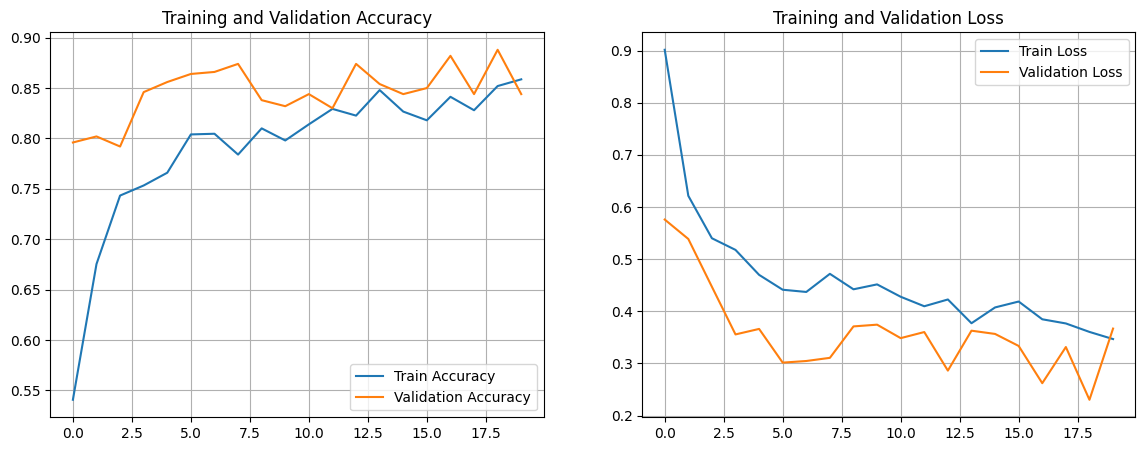

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Оцінка якості моделі
Розрахуємо фінальні метрики: Accuracy, Precision, Recall, F1-score.

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


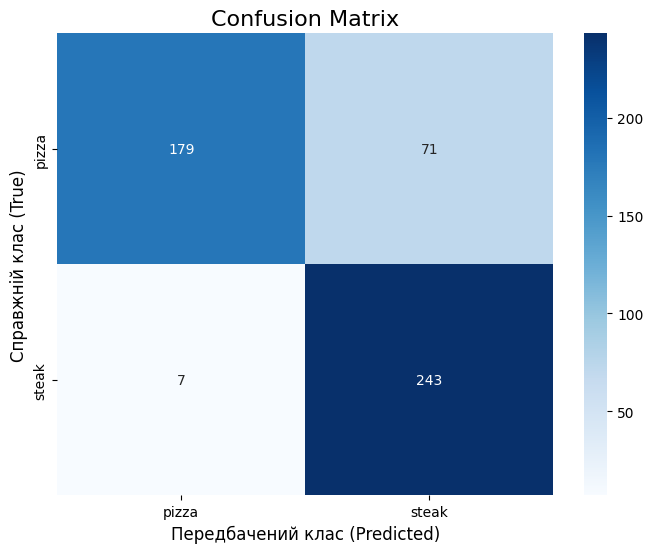


Classification Report:
              precision    recall  f1-score   support

       pizza       0.96      0.72      0.82       250
       steak       0.77      0.97      0.86       250

    accuracy                           0.84       500
   macro avg       0.87      0.84      0.84       500
weighted avg       0.87      0.84      0.84       500



In [13]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Отримання прогнозів
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype("int32") 
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# 2. Розрахунок матриці
cm = confusion_matrix(y_true, y_pred)

# 3. Візуалізація (Beautiful Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True,         # Показати цифри у клітинках
            fmt='d',            # Формат цифр (d - цілі числа, щоб не було 1e2)
            cmap='Blues',       # Колірна гама (можна 'Greens', 'Reds', 'YlGnBu')
            xticklabels=class_names, # Підписи осі X
            yticklabels=class_names  # Підписи осі Y
           )

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Справжній клас (True)', fontsize=12)
plt.xlabel('Передбачений клас (Predicted)', fontsize=12)
plt.show()

# 4. Текстовий звіт (для деталізації Precision/Recall)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Практичне застосування
Розроблена модель може бути інтегрована в:

Мобільний застосунок (через TensorFlow Lite) для ресторанів, щоб автоматично визначати тип страви на фото для меню.

Web-сервіс для аналізу фотографій користувачів у соціальних мережах, що цікавляться їжею

Висновки
У ході лабораторної роботи було:

Створено/завантажено набір даних для бінарної класифікації (Варіант 9).

Виконано попередню обробку: нормалізацію пікселів та аугментацію (обертання, зсуви, масштабування).

Побудовано модель CNN з 3 згортковими шарами, MaxPooling та Dropout.

Проведено навчання моделі протягом 20 епох.

Оцінено якість моделі. Отримані результати Accuracy, Precision, Recall та F1-score показують здатність моделі розрізняти обрані класи.

Якщо модель перенавчається (точність на тренуванні значно вища за валідацію), слід збільшити Dropout або додати більше даних для аугментації.